In [4]:
import sys
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import seaborn as sns
import sklearn
import matplotlib
import xgboost as xgb
import scipy
import skimage
import nilearn
# ==== INFO VERSIONS ====
print(f"Python : {sys.version.split()[0]}")
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Nibabel version: ", nib.__version__)
print("OpenCV version: ", cv2.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("Seaborn version: ", sns.__version__)

print("Matplotlib version: ", matplotlib.__version__)
print("XGBoost version: ", xgb.__version__)
print("Scipy version: ", scipy.__version__)
print("Scikit-image version: ", skimage.__version__)
print("Nilearn version: ", nilearn.__version__)

Python : 3.11.12
Numpy version:  1.26.4
Pandas version:  2.2.3
Nibabel version:  5.3.2
OpenCV version:  4.11.0
Scikit-learn version:  1.6.1
Seaborn version:  0.13.2
Matplotlib version:  3.10.0
XGBoost version:  2.1.4
Scipy version:  1.15.2
Scikit-image version:  0.25.2
Nilearn version:  0.11.1


In [17]:
from scipy.stats import kurtosis, skew
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Pour la recherche d'hyperparamètres
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, ttest_ind, mannwhitneyu, shapiro

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")



In [6]:
###############################################################################
#                              Feature Engineering                            #
###############################################################################

# ----------------------------------------------------
# Feature Engineering - Anatomy
# ----------------------------------------------------
def compute_binary_volume(mask: np.ndarray, spacing: np.ndarray) -> float:
    return float(mask.sum() * np.prod(spacing))

# ----------------------------------------------------
# Feature Engineering - Geometry
# ----------------------------------------------------
def compute_wall_thickness(mask3d: np.ndarray, spacing: np.ndarray):
    scale = np.sqrt(spacing[0] + spacing[1])
    thicknesses = [
        cv2.distanceTransform(mask3d[:, :, z].astype(np.uint8), cv2.DIST_L2, 5).ptp() * scale
        for z in range(mask3d.shape[2])
    ]
    arr = np.asarray(thicknesses)
    return arr.mean(), arr.std(), arr.max(), arr.min()

def compute_wall_circularity(mask3d: np.ndarray, spacing: np.ndarray) -> float:
    circ = []
    scale = np.sqrt(spacing[0] + spacing[1])
    for z in range(mask3d.shape[2]):
        contours, _ = cv2.findContours(mask3d[:, :, z].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            area = cv2.contourArea(contours[0])
            perimeter = cv2.arcLength(contours[0], True) * scale
            if perimeter:
                circ.append(4 * np.pi * area / perimeter**2)
    return float(np.mean(circ)) if circ else 0.0

def compute_wall_perimeter(mask3d: np.ndarray, spacing: np.ndarray):
    perimeters = []
    scale = np.sqrt(spacing[0] + spacing[1])
    for z in range(mask3d.shape[2]):
        contours, _ = cv2.findContours(mask3d[:, :, z].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeters.extend(cv2.arcLength(c, True) * scale for c in contours)
    arr = np.asarray(perimeters)
    return arr.mean(), arr.max(), arr.min() if len(arr) else (0.0, 0.0, 0.0)



###############################################################################
#                             Patient‑level Features                          #
###############################################################################

def extract_patient_features(pid: int, root_dir: Path, *, label: int | None = None) -> dict:
    sid = f"{pid:03d}"
    seg_ed = nib.load(root_dir / sid / f"{sid}_ED_seg.nii")
    seg_es = nib.load(root_dir / sid / f"{sid}_ES_seg.nii")

    d_ed, d_es = seg_ed.get_fdata().astype(int), seg_es.get_fdata().astype(int)
    v_ed, v_es = np.array(seg_ed.header.get_zooms()), np.array(seg_es.header.get_zooms())

    record = {"Id": pid}
    if label is not None:
        record["Category"] = label

    # --- Anatomy features ---
    anatomy_features = {
        "vol_rv_ED": compute_binary_volume(d_ed == 1, v_ed),
        "vol_myo_ED": compute_binary_volume(d_ed == 2, v_ed),
        "vol_lv_ED": compute_binary_volume(d_ed == 3, v_ed),
        "vol_rv_ES": compute_binary_volume(d_es == 1, v_es),
        "vol_myo_ES": compute_binary_volume(d_es == 2, v_es),
        "vol_lv_ES": compute_binary_volume(d_es == 3, v_es),
    }
    anatomy_features.update({
        "ratio_rv_lv_ED": anatomy_features["vol_rv_ED"] / anatomy_features["vol_lv_ED"] if anatomy_features["vol_lv_ED"] else 0.0,
        "ratio_myo_lv_ED": anatomy_features["vol_myo_ED"] / anatomy_features["vol_lv_ED"] if anatomy_features["vol_lv_ED"] else 0.0,
        "ratio_rv_lv_ES": anatomy_features["vol_rv_ES"] / anatomy_features["vol_lv_ES"] if anatomy_features["vol_lv_ES"] else 0.0,
        "ratio_myo_lv_ES": anatomy_features["vol_myo_ES"] / anatomy_features["vol_lv_ES"] if anatomy_features["vol_lv_ES"] else 0.0,
    })

    # --- Geometry features ---
    th_mean_ed, th_std_ed, th_max_ed, th_min_ed = compute_wall_thickness(d_ed == 2, v_ed)
    th_mean_es, th_std_es, th_max_es, th_min_es = compute_wall_thickness(d_es == 2, v_es)
    peri_mean_ed, peri_max_ed, peri_min_ed = compute_wall_perimeter(d_ed == 2, v_ed)
    peri_mean_es, peri_max_es, peri_min_es = compute_wall_perimeter(d_es == 2, v_es)

    geometry_features = {
        "th_mean_ED": th_mean_ed, "th_std_ED": th_std_ed, "th_max_ED": th_max_ed, "th_min_ED": th_min_ed,
        "circ_ED": compute_wall_circularity(d_ed == 2, v_ed),
        "peri_mean_ED": peri_mean_ed, "peri_max_ED": peri_max_ed, "peri_min_ED": peri_min_ed,
        "th_mean_ES": th_mean_es, "th_std_ES": th_std_es, "th_max_ES": th_max_es, "th_min_ES": th_min_es,
        "circ_ES": compute_wall_circularity(d_es == 2, v_es),
        "peri_mean_ES": peri_mean_es, "peri_max_ES": peri_max_es, "peri_min_ES": peri_min_es,
    }

    # --- Functional features ---
    function_features = {
        "EF_lv": (anatomy_features["vol_lv_ED"] - anatomy_features["vol_lv_ES"]) / anatomy_features["vol_lv_ED"] if anatomy_features["vol_lv_ED"] else 0.0,
        "EF_rv": (anatomy_features["vol_rv_ED"] - anatomy_features["vol_rv_ES"]) / anatomy_features["vol_rv_ED"] if anatomy_features["vol_rv_ED"] else 0.0,
    }

    # --- Diff features ---
    diff_map = ((d_ed == 2).astype(int) - (d_es == 2).astype(int)).ravel() * np.prod(v_ed)
    diff_features = {
        "diff_med": float(np.median(diff_map)),
        "diff_std": float(np.std(diff_map)),
        "diff_kurt": float(kurtosis(diff_map)),
        "diff_skew": float(skew(diff_map)),
    }

    # --- Final assembly ---
    record.update(anatomy_features)
    record.update(geometry_features)
    record.update(function_features)
    record.update(diff_features)

    return record


def load_features(meta_csv: str, root: str, *, is_train: bool) -> pd.DataFrame:
        meta = pd.read_csv(meta_csv)
        root_dir = Path(root)
        rows = [
            extract_patient_features(int(row.Id), root_dir, label=int(row.Category) if is_train else None)
            for _, row in meta.iterrows()
        ]
        return pd.DataFrame(rows)


Accuracy moyenne : 0.9500


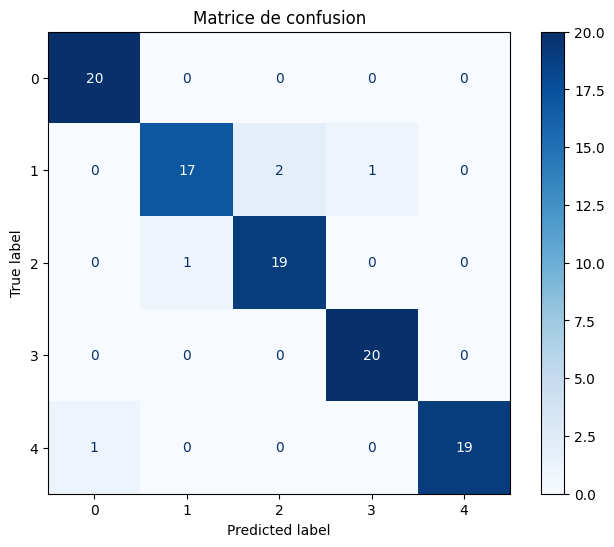

In [7]:
# 1. Données d'entraînement
df_train = load_features("metadataTrain.csv", "data/Train", is_train=True)

X, y = df_train.drop(columns=["Id", "Category"]), df_train["Category"].astype(int)

# modèle
rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# 3. Cross-validation prédictive
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
y_pred = cross_val_predict(rf, X, y, cv=cv)
print(f"Accuracy moyenne : {cross_val_score(rf, X, y, cv=cv).mean():.4f}")

# 4. Matrice de confusion 
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matrice de confusion")
plt.grid(False)
plt.show()



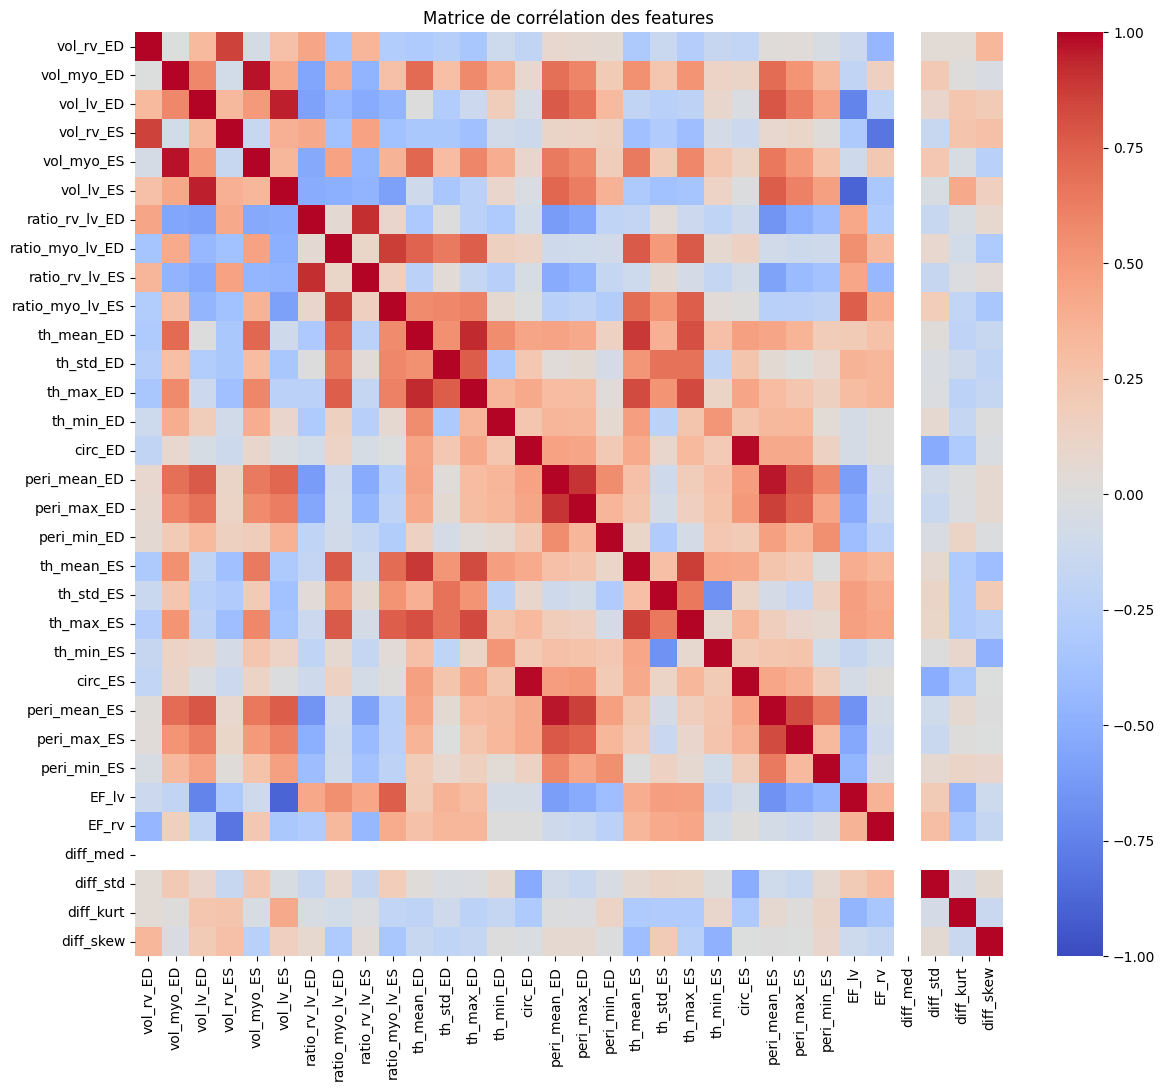

           Feature1        Feature2  Correlation
336         circ_ED         circ_ES     0.987121
32       vol_myo_ED      vol_myo_ES     0.969969
352    peri_mean_ED    peri_mean_ES     0.967442
61        vol_lv_ED       vol_lv_ES     0.950172
256      th_mean_ED       th_max_ED     0.927413
166  ratio_rv_lv_ED  ratio_rv_lv_ES     0.914242
345    peri_mean_ED     peri_max_ED     0.900955


In [8]:
# Matrice de corrélation
corr = X.corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Matrice de corrélation des features")
plt.show()

# Liste des features très corrélées
threshold = 0.90

high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
    .query("abs(Correlation) > @threshold")
    .sort_values("Correlation", key=np.abs, ascending=False)
)

print(high_corr)



Features à faible variance (<0.01) : ['circ_ED', 'circ_ES', 'diff_med']


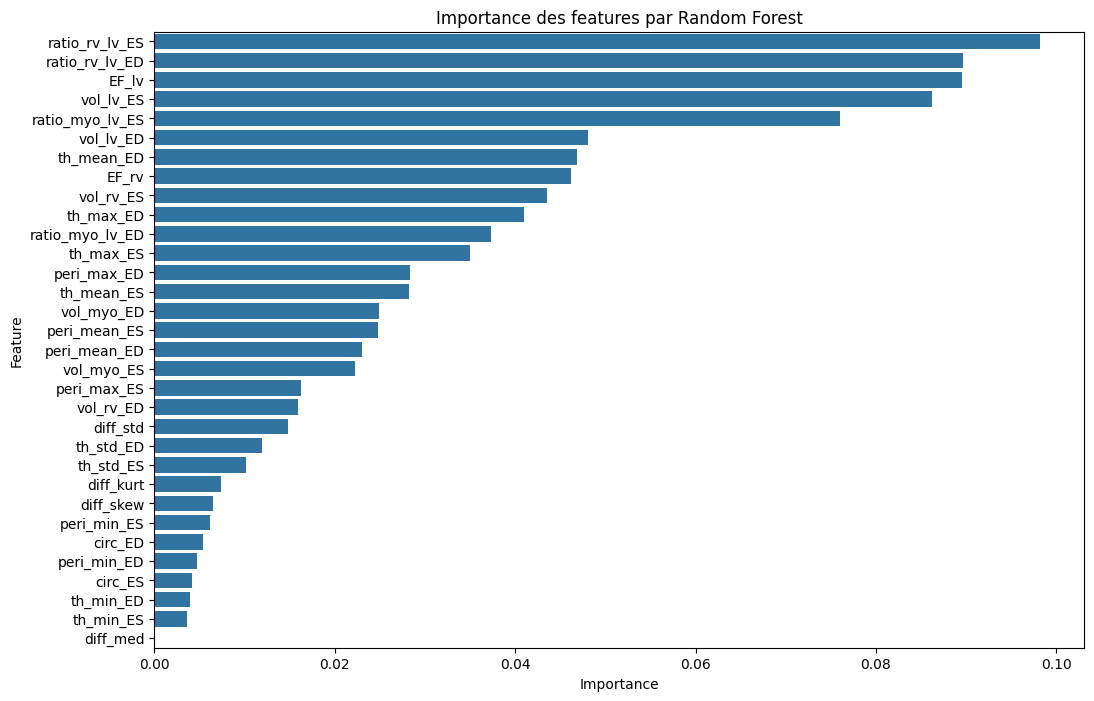

            Feature  Importance
8    ratio_rv_lv_ES    0.098201
6    ratio_rv_lv_ED    0.089597
26            EF_lv    0.089514
5         vol_lv_ES    0.086190
9   ratio_myo_lv_ES    0.076030
2         vol_lv_ED    0.048057
10       th_mean_ED    0.046896
27            EF_rv    0.046137
3         vol_rv_ES    0.043530
12        th_max_ED    0.041004
7   ratio_myo_lv_ED    0.037295
20        th_max_ES    0.035026
16      peri_max_ED    0.028364
18       th_mean_ES    0.028282
1        vol_myo_ED    0.024913
23     peri_mean_ES    0.024820
15     peri_mean_ED    0.023069
4        vol_myo_ES    0.022224
24      peri_max_ES    0.016270
0         vol_rv_ED    0.015932
29         diff_std    0.014777
11        th_std_ED    0.011934
19        th_std_ES    0.010137
30        diff_kurt    0.007431
31        diff_skew    0.006449
25      peri_min_ES    0.006211
14          circ_ED    0.005337
17      peri_min_ED    0.004690
22          circ_ES    0.004216
13        th_min_ED    0.003901
21      

In [9]:
# Calcul de la variance de chaque feature
variances = X.var()

# détecter des features quasi constantes
low_variance_features = variances[variances < 1e-2].index.tolist()

print(f"Features à faible variance (<0.01) : {low_variance_features}")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

rf.fit(X, y)

# Importances
importances = rf.feature_importances_
feat_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_importances = feat_importances.sort_values("Importance", ascending=False)

# Barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=feat_importances, x="Importance", y="Feature")
plt.title("Importance des features par Random Forest")
plt.show()

print(feat_importances)


In [10]:
# 1. Retirer les features à très faible variance
X_cleaned = X.drop(columns=['circ_ED', 'circ_ES', 'diff_med'])

# 2. Retirer une feature par paire très corrélée
features_to_remove = [
    'vol_myo_ES',  # vol_myo_ED et vol_myo_ES corrélés → vol_myo_ES out
    'peri_mean_ES',# peri_mean_ED et peri_mean_ES corrélés → peri_mean_ES out
    'vol_lv_ES',   # vol_lv_ED et vol_lv_ES corrélés → vol_lv_ES out
    'th_max_ED',   # th_mean_ED et th_max_ED corrélés → th_max_ED out
    'ratio_rv_lv_ES', # ratio_rv_lv_ED et ratio_rv_lv_ES corrélés → ratio_rv_lv_ES out
    'peri_max_ED'  # peri_mean_ED et peri_max_ED corrélés → peri_max_ED out
]

X_reduit = X_cleaned.drop(columns=features_to_remove)

print(f"Nombre de features après nettoyage : {X_reduit.shape[1]}")


Nombre de features après nettoyage : 23


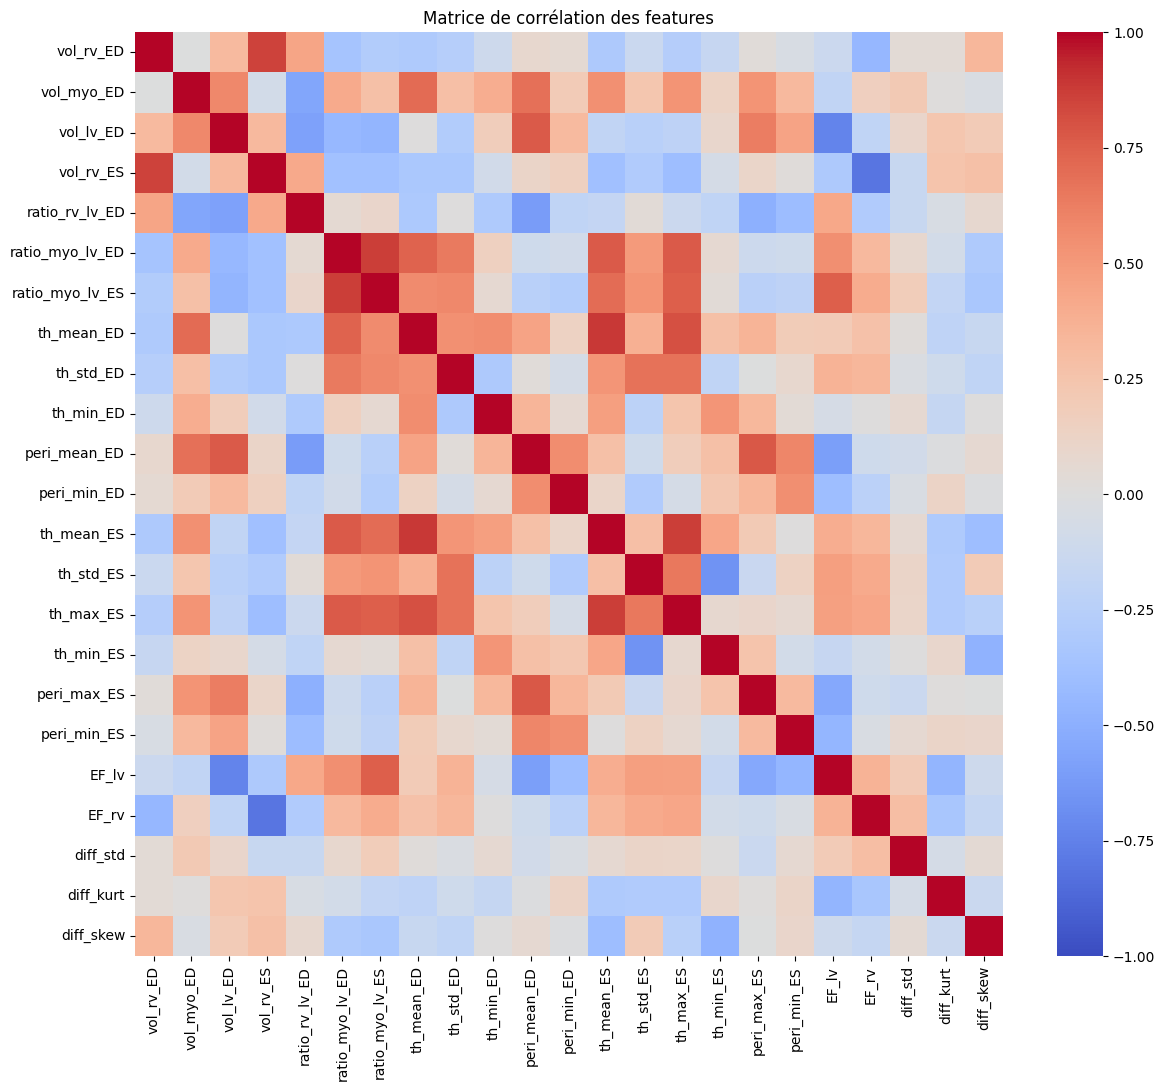

Empty DataFrame
Columns: [Feature1, Feature2, Correlation]
Index: []


In [11]:
# Matrice de corrélation
corr = X_reduit.corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Matrice de corrélation des features")
plt.show()

# Liste des features très corrélées
threshold = 0.90

high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
    .query("abs(Correlation) > @threshold")
    .sort_values("Correlation", key=np.abs, ascending=False)
)

print(high_corr)



Accuracy moyenne : 0.9400


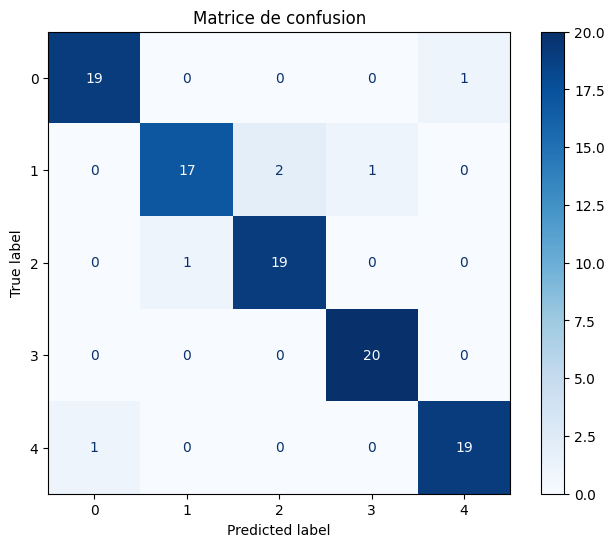

In [12]:
# modèle
rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# 3. Cross-validation prédictive
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
y_pred = cross_val_predict(rf, X_reduit, y, cv=cv)
print(f"Accuracy moyenne : {cross_val_score(rf, X_reduit, y, cv=cv).mean():.4f}")

# 4. Matrice de confusion 
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matrice de confusion")
plt.grid(False)
plt.show()



In [13]:
# Définir la cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
param_distributions = {
    "n_estimators": randint(100, 1200),
    "max_depth": [None] + list(range(5, 50, 5)),
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log_loss"],
}

search = RandomizedSearchCV(
    rf, param_distributions, n_iter=100, cv=cv, random_state=0, n_jobs=-1, verbose=1
)
search.fit(X, y)


print("Best parameters found:")
print(search.best_params_)

print(f"Meilleure accuracy CV : {search.best_score_:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 651}
Meilleure accuracy CV : 0.9500


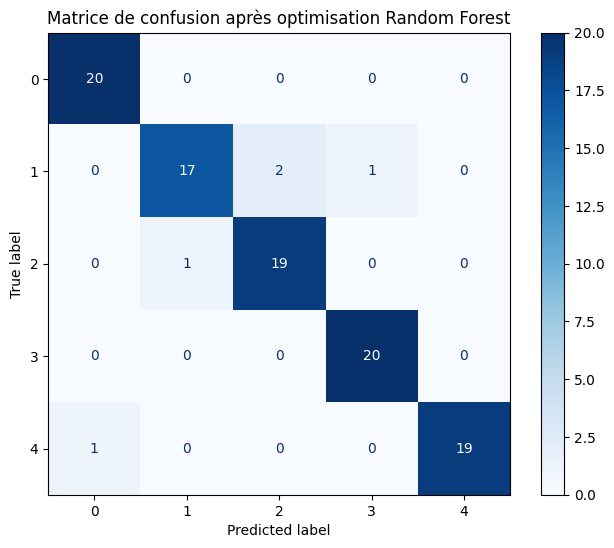

In [14]:
# Définir le RandomForest optimisé
rf_best = search.best_estimator_

# Cross-validation prédictive
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
y_pred_best = cross_val_predict(rf_best, X, y, cv=cv)

# Matrice de confusion
cm = confusion_matrix(y, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matrice de confusion après optimisation Random Forest")
plt.grid(False)
plt.show()


In [15]:
def train_random_forest(X: pd.DataFrame, y: pd.Series) -> RandomForestClassifier:
        rf = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=8,
    n_estimators=651,
    random_state=0,
    n_jobs=-1
)
        rf.fit(X, y)
        return rf


def train_gradient_boosting(X: pd.DataFrame, y: pd.Series) -> GradientBoostingClassifier:
        gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, random_state=34)
        gb.fit(X, y)
        return gb


def train_xgb_classifier(X: pd.DataFrame, y_bin: pd.Series) -> XGBClassifier:
        xgb = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=100,
            learning_rate=1,
            max_depth=3,
            random_state=34,
            n_jobs=-1,
        )
        xgb.fit(X, y_bin)
        return xgb


def dynamic_override(pred_gb, proba_gb, gb_classes, pred_xgb, proba_xgb_bin, pred_xgb_bin):
    # Crée un dictionnaire pour associer chaque classe GB à son index de probabilité
    idx_gb = {cls: i for i, cls in enumerate(gb_classes)}

    # Copie des prédictions GB pour pouvoir les modifier
    final = pred_gb.copy()

    # Parcourt chaque échantillon (i) avec les prédictions GB (pg) et XGB (px)
    for i, (pg, px) in enumerate(zip(pred_gb, pred_xgb)):
        # Compare la probabilité XGB pour la classe prédite à celle de GB
        # Si la probabilité XGB est plus élevée, on remplace la prédiction finale par px
        if proba_xgb_bin[i, pred_xgb_bin[i]] > proba_gb[i, idx_gb[pg]]:
            final[i] = px

    # Retourne les prédictions finales combinées
    return final


In [18]:
ALL_FEAT = X.columns.tolist()
# --- 1. Sous-ensemble classes 1 et 2 ---
mask_12 = y.isin([1, 2])
X12 = X.loc[mask_12]
y_bin = y.loc[mask_12].replace({1: 0, 2: 1})

# --- 2. p-values univariées ---
def compute_pvalue(col: str) -> float:
    g0, g1 = X12.loc[y_bin == 0, col], X12.loc[y_bin == 1, col]
    if g0.std() == 0 or g1.std() == 0:
        return 1.0
    normal = (shapiro(g0).pvalue > 0.05) and (shapiro(g1).pvalue > 0.05)
    stat, p = (ttest_ind(g0, g1, equal_var=False) if normal
               else mannwhitneyu(g0, g1, alternative="two-sided"))
    return p

pvals = pd.Series({col: compute_pvalue(col) for col in ALL_FEAT})

# --- 3. Importances GB et XGB ---
gb = train_gradient_boosting(X12, y_bin)
xgb = train_xgb_classifier(X12, y_bin)
imp_gb = pd.Series(gb.feature_importances_, index=ALL_FEAT)
imp_xgb = pd.Series(xgb.feature_importances_, index=ALL_FEAT)

# --- 4. Regroupement des variables par famille ---
families = {}
for col in ALL_FEAT:
    key = None
    if col.startswith(("vol_", "ratio_")):
        key = col.split("_ED")[0].split("_ES")[0]
    elif col.startswith("EF_") or col == "th_mean_ES":
        key = col.split("_")[0]
    if key:
        families.setdefault(key, []).append(col)

# --- 5. Sélection des variables discriminantes ---
def is_discriminant(col: str) -> bool:
    return (imp_gb[col] >= 0.01) or (imp_xgb[col] >= 0.01) or (pvals[col] < 0.01)

selected = []
for key, cols in families.items():
    if key in {"EF", "th_mean"}:
        selected += [col for col in cols if is_discriminant(col)]
        continue

    disc_cols = [col for col in cols if is_discriminant(col)]
    if not disc_cols:
        continue

    if len(cols) == 2:  # typiquement ED/ES
        selected += cols
    else:
        selected += disc_cols
        for col in disc_cols:
            twin = col.replace("_ED", "_ES") if "_ED" in col else col.replace("_ES", "_ED")
            if twin in cols and twin not in selected:
                selected.append(twin)

# --- 6. Ordre logique final ---
block_order = {
    "vol_ED": 0, "ratio_ED": 1, "vol_ES": 2,
    "th": 3, "ratio_ES": 4, "EF": 5
}

def block_key(col: str) -> tuple:
    if col.startswith("vol_") and col.endswith("_ED"):
        return (block_order["vol_ED"], {"rv": 0, "myo": 1, "lv": 2}[col.split("_")[1]])
    if col.startswith("ratio_") and col.endswith("_ED"):
        return (block_order["ratio_ED"], {"rv_lv": 0, "myo_lv": 1}["_".join(col.split("_")[1:3])])
    if col.startswith("vol_") and col.endswith("_ES"):
        return (block_order["vol_ES"], {"rv": 0, "myo": 1, "lv": 2}[col.split("_")[1]])
    if col == "th_mean_ES":
        return (block_order["th"], 0)
    if col.startswith("ratio_") and col.endswith("_ES"):
        return (block_order["ratio_ES"], {"rv_lv": 0, "myo_lv": 1}["_".join(col.split("_")[1:3])])
    if col.startswith("EF_"):
        return (block_order["EF"], {"lv": 0, "rv": 1}[col.split("_")[1]])
    raise ValueError(f"Unknown feature format: {col}")

FEAT2_final = sorted(selected, key=block_key)

print(f"FEAT2 : {FEAT2_final} ({len(FEAT2_final)} vars)")

f = pd.DataFrame({
    "p-val": pvals[FEAT2_final],
    "GB_imp": imp_gb[FEAT2_final],
    "XGB_imp": imp_xgb[FEAT2_final]
}).round(4)
print(f)

# --- 8. Validation croisée GB et XGB ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
# GB 
acc_gb = cross_val_score(
    gb, X12[FEAT2_final], y_bin, cv=cv
).mean()

# XGB 
pipe_val = make_pipeline(
    StandardScaler(),
    xgb
)
acc_xgb = cross_val_score(
    pipe_val, X12[FEAT2_final], y_bin, cv=cv
).mean()

print(f"\nGB  accuracy (CV) : {acc_gb:.3f}")
print(f"XGB accuracy (CV): {acc_xgb:.3f}")
FEAT2 = FEAT2_final

FEAT2 : ['vol_rv_ED', 'vol_myo_ED', 'vol_lv_ED', 'ratio_myo_lv_ED', 'vol_rv_ES', 'vol_myo_ES', 'vol_lv_ES', 'th_mean_ES', 'ratio_myo_lv_ES', 'EF_lv', 'EF_rv'] (11 vars)
                  p-val  GB_imp  XGB_imp
vol_rv_ED        0.0018  0.0000   0.0000
vol_myo_ED       0.0000  0.0000   0.0000
vol_lv_ED        0.0000  0.0000   0.1226
ratio_myo_lv_ED  0.0018  0.0853   0.0000
vol_rv_ES        0.0001  0.0000   0.0000
vol_myo_ES       0.0001  0.0000   0.0000
vol_lv_ES        0.0000  0.7243   0.6650
th_mean_ES       0.0275  0.0000   0.0264
ratio_myo_lv_ES  0.0000  0.0000   0.0000
EF_lv            0.0000  0.0000   0.0000
EF_rv            0.0000  0.0896   0.0377

GB  accuracy (CV) : 0.750
XGB accuracy (CV): 0.925


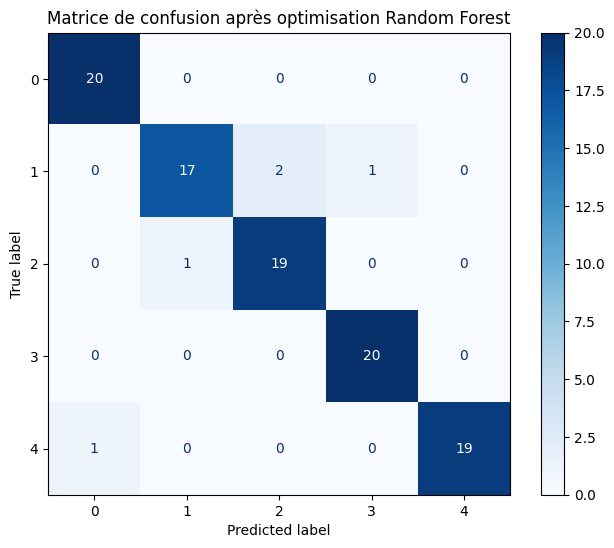

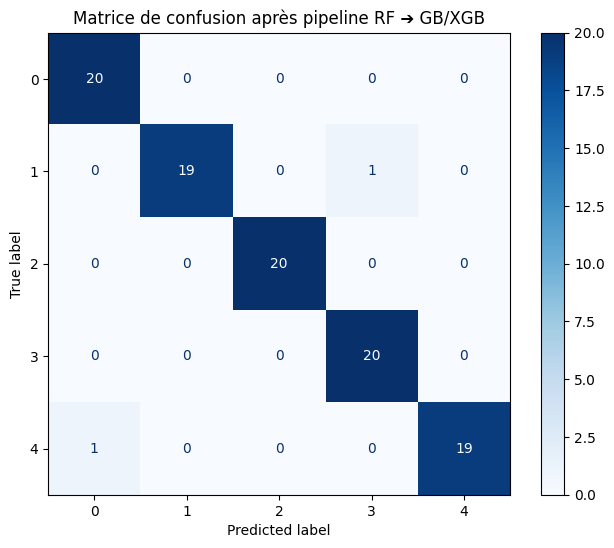

In [22]:
# --- 1. Paramètres de cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rf = train_random_forest(X, y)

# --- 3. Prédictions cross-validées du niveau 1 (RF) ---
pred_lvl1_cv = cross_val_predict(rf, X, y, cv=cv)

# Matrice de confusion
cm = confusion_matrix(y, pred_lvl1_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matrice de confusion après optimisation Random Forest")
plt.grid(False)
plt.show()
# --- 4. Spécialisation pour les prédictions {1,2} ---
mask_tr = y.isin([1, 2])
mask_pred = np.isin(pred_lvl1_cv, [1, 2])

# Préparer X pour GB et XGB
X2_tr_gb = X.loc[mask_tr, FEAT2]
X2_pred_gb = X.loc[mask_pred, FEAT2]

# Préparer y pour GB et XGB
y2_tr = y[mask_tr]

# Entraîner GB et XGB sur tout {1,2} train
gb2 = train_gradient_boosting(X2_tr_gb, y2_tr)

y2_tr_bin = y2_tr.map({1: 0, 2: 1})
xgb2 = train_xgb_classifier(X2_tr_gb, y2_tr_bin)

# Prédire GB/XGB pour les prédictions {1,2}
proba_gb = gb2.predict_proba(X2_pred_gb)
pred_gb = gb2.predict(X2_pred_gb)

proba_xgb_bin = xgb2.predict_proba(X2_pred_gb)
pred_xgb_bin = xgb2.predict(X2_pred_gb)
pred_xgb = np.where(pred_xgb_bin == 0, 1, 2)

# Combine GB/XGB pour classes {1,2}
pred_final_subset = dynamic_override(
    pred_gb, proba_gb, gb2.classes_,
    pred_xgb, proba_xgb_bin, pred_xgb_bin
)

# --- 5. Reconstruire prédictions finales ---
final_pred = pred_lvl1_cv.copy()
final_pred[mask_pred] = pred_final_subset

# --- 6. Matrice de confusion finale ---
cm = confusion_matrix(y, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Matrice de confusion après pipeline RF ➔ GB/XGB")
plt.grid(False)
plt.show()


---
Ici je voudrais voir qu'elle est la classe où le modele fait l'erreur  

In [23]:
# Lire et afficher submission.csv
submission = pd.read_csv("submission.csv")

print(f"\n Shape de submission.csv: {submission.shape}")

# Afficher la répartition des prédictions
print("\nRépartition des prédictions :")
print(submission["Category"].value_counts().sort_index())

# Trouver les patients prédits en classe 1
patients_class1 = submission[submission["Category"] == 1]
print("\n Patients prédits en classe 1 :")
print(patients_class1)


 Shape de submission.csv: (50, 2)

Répartition des prédictions :
Category
0    10
1    11
2     9
3    10
4    10
Name: count, dtype: int64

 Patients prédits en classe 1 :
     Id  Category
5   106         1
8   109         1
12  113         1
19  120         1
21  122         1
23  124         1
31  132         1
34  135         1
37  138         1
40  141         1
44  145         1
